## Filtering TimeLapse Images

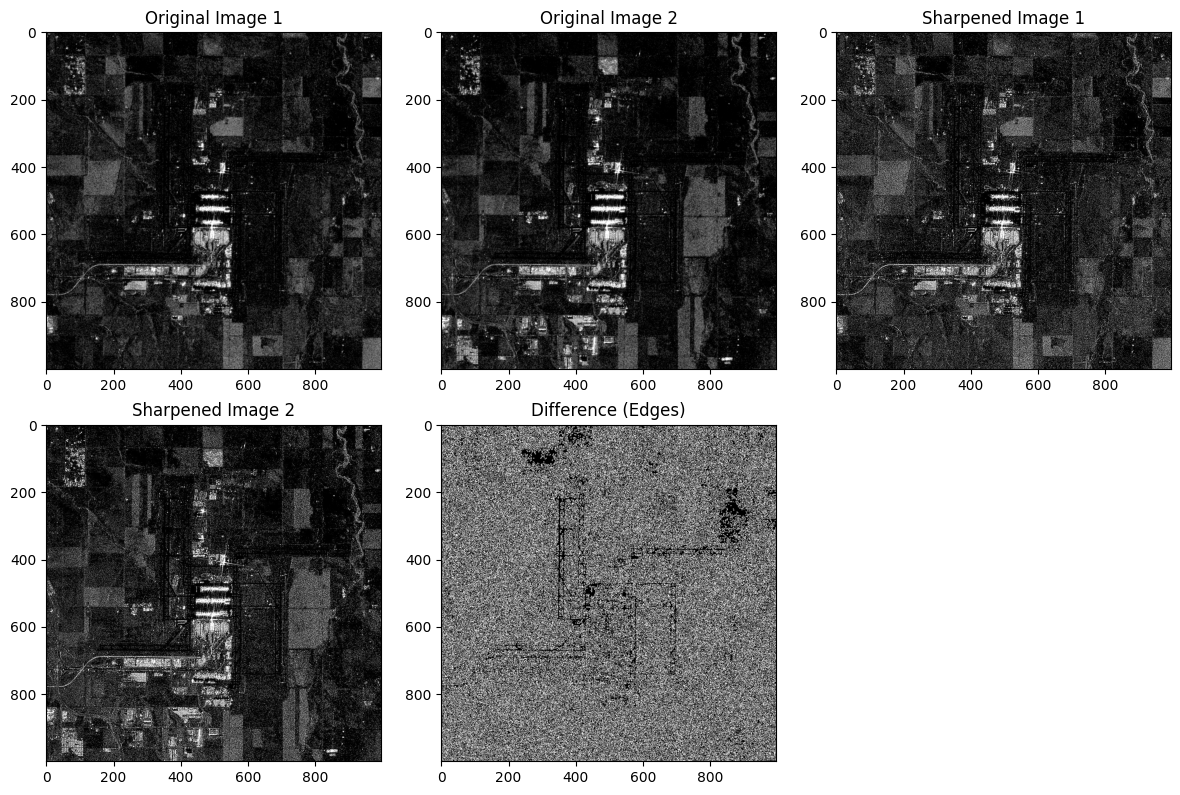

In [105]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def read_images(folder_path):
    # Read all images in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    if len(image_files) < 2:
        raise ValueError("The folder must contain at least two images for comparison.")
    
    image1 = cv2.imread(os.path.join(folder_path, image_files[0]), cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(os.path.join(folder_path, image_files[86]), cv2.IMREAD_GRAYSCALE)
    return image1, image2

def sharpen_image(image):
    # Sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def apply_edge_detection(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

def compare_images(image1, image2):
    # Compute the absolute difference
    difference = cv2.absdiff(image1, image2)
    return difference


folder_path = 'DEN_timelapse'  # Path to the folder containing images

# Step 1: Read Images
image1, image2 = read_images(folder_path)

# Step 2: Preprocess Images
sharpened1 = sharpen_image(image1)
sharpened2 = sharpen_image(image2)

# Step 3: Edge Detection
edges1 = apply_edge_detection(sharpened1)
edges2 = apply_edge_detection(sharpened2)

# Step 4: Compare Images
difference = compare_images(edges1, edges2)

# Step 5: Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title('Original Image 1')
plt.imshow(image1, cmap='gray')
plt.subplot(2, 3, 2)
plt.title('Original Image 2')
plt.imshow(image2, cmap='gray')
plt.subplot(2, 3, 3)
plt.title('Sharpened Image 1')
plt.imshow(sharpened1, cmap='gray')
plt.subplot(2, 3, 4)
plt.title('Sharpened Image 2')
plt.imshow(sharpened2, cmap='gray')
plt.subplot(2, 3, 5)
plt.title('Difference (Edges)')
plt.imshow(difference, cmap='gray')
plt.tight_layout()
plt.show()



In [32]:
def histogram_equalization(image):
    # Enhance contrast using histogram equalization
    equalized = cv2.equalizeHist(image)
    return equalized

# Gaussian Blur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def threshold_image(image):
    # Apply thresholding to emphasize changes
    _, thresholded = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
    return thresholded

def morphological_filter(image):
    # Morphological transformations to segment features
    kernel = np.ones((5, 5), np.uint8)
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened

def compute_difference(image1, image2):
    # Compute the absolute difference
    difference = cv2.absdiff(image1, image2)
    return difference

def zoom_into_area(image, region):
    # Crop the image to the specified region
    x, y, w, h = region  # Region as (x, y, width, height)
    return image[y:y+h, x:x+w]

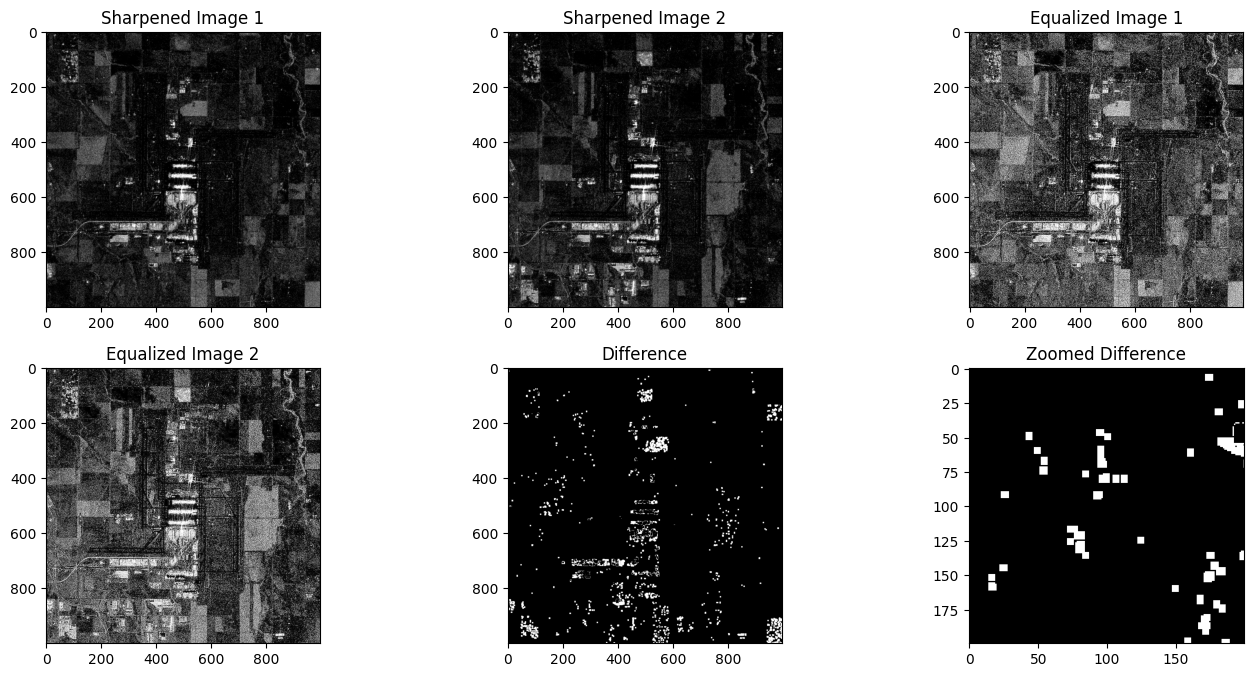

In [34]:
folder_path = 'DEN_timelapse' 

image1, image2 = read_images(folder_path)

equalized1 = histogram_equalization(sharpened1)
equalized2 = histogram_equalization(sharpened2)

thresholded1 = threshold_image(equalized1)
thresholded2 = threshold_image(equalized2)

opened1 = morphological_filter(thresholded1)
opened2 = morphological_filter(thresholded2)
difference = compute_difference(opened1, opened2)

# Step 4: Zoom into Significant Change Area (Example Region)
# Define a region of interest (ROI) for zooming (manually or using largest difference areas)
zoom_region = (200, 800, 200, 200)  # Example region: (x, y, width, height)
zoomed_difference = zoom_into_area(difference, zoom_region)

# Step 5: Visualization
plt.figure(figsize=(14, 10))
plt.subplot(3, 3, 1)
plt.title('Sharpened Image 1')
plt.imshow(image1, cmap='gray')
plt.subplot(3, 3, 2)
plt.title('Sharpened Image 2')
plt.imshow(image2, cmap='gray')
plt.subplot(3, 3, 3)
plt.title('Equalized Image 1')
plt.imshow(equalized1, cmap='gray')
plt.subplot(3, 3, 4)
plt.title('Equalized Image 2')
plt.imshow(equalized2, cmap='gray')
plt.subplot(3, 3, 5)
plt.title('Difference')
plt.imshow(difference, cmap='gray')
plt.subplot(3, 3, 6)
plt.title('Zoomed Difference')
plt.imshow(zoomed_difference, cmap='gray')
plt.tight_layout()
plt.show()

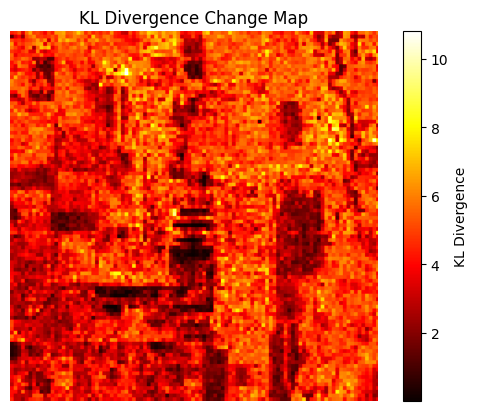

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import entropy

def normalize_image(image):
    """
    Normalize image to represent a probability distribution.
    :param image: Input image (numpy array).
    :return: Normalized image (pixel values sum to 1).
    """
    image = image.astype(np.float32)
    image_sum = np.sum(image)
    if image_sum == 0:
        return image
    return image / image_sum

def kl_divergence(image1, image2, block_size=8):
    """
    Computes KL divergence for blocks in two images.
    :param image1: First image (numpy array).
    :param image2: Second image (numpy array).
    :param block_size: Size of the blocks to divide the image.
    :return: KL divergence map.
    """
    # Ensure images are normalized to probability distributions
    image1 = normalize_image(image1)
    image2 = normalize_image(image2)
    
    height, width = image1.shape
    kl_map = np.zeros((height, width))
    
    # Process blocks
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block1 = image1[i:i + block_size, j:j + block_size]
            block2 = image2[i:i + block_size, j:j + block_size]
            
            # Flatten blocks for probability comparison
            block1_flat = block1.flatten() + 1e-10  # Add small value to avoid log(0)
            block2_flat = block2.flatten() + 1e-10
            
            # Normalize within blocks
            block1_flat /= np.sum(block1_flat)
            block2_flat /= np.sum(block2_flat)
            
            # Compute KL divergence
            kl_value = entropy(block1_flat, block2_flat)
            kl_map[i:i + block_size, j:j + block_size] = kl_value
    
    return kl_map



# Ensure the images are the same size
if image1.shape != image2.shape:
    raise ValueError("Images must be the same size for comparison.")

# Compute KL divergence
kl_map = kl_divergence(equalized1, equalized2, block_size=10)

# Display results
plt.imshow(kl_map, cmap='hot')
plt.colorbar(label="KL Divergence")
plt.title("KL Divergence Change Map")
plt.axis("off")
plt.show()


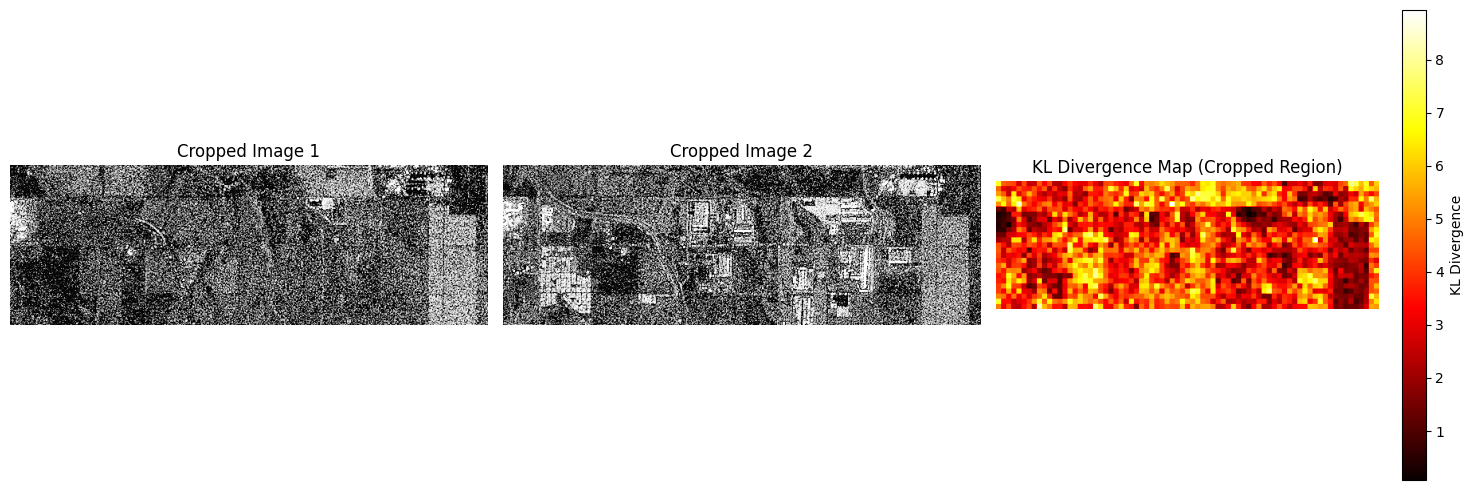

In [49]:
import matplotlib.pyplot as plt

def crop_image(image, top_left, bottom_right):
    """
    Crop the image to a specific region.
    :param image: Input image (numpy array).
    :param top_left: Tuple (row, col) for the top-left corner of the crop.
    :param bottom_right: Tuple (row, col) for the bottom-right corner of the crop.
    :return: Cropped image.
    """
    return image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

# Define the cropping region (adjust as needed)
top_left = (800, 0)  # Top-left corner of the crop
bottom_right = (1000, 600)  # Bottom-right corner of the crop

# Crop both images
cropped_image1 = crop_image(equalized1, top_left, bottom_right)
cropped_image2 = crop_image(equalized2, top_left, bottom_right)

# Perform KL divergence on the cropped region
kl_map_cropped = kl_divergence(cropped_image1, cropped_image2, block_size=8)

# Plot the original cropped images and the KL divergence map
plt.figure(figsize=(15, 5))

# Display cropped image1
plt.subplot(1, 3, 1)
plt.imshow(cropped_image1, cmap='gray')
plt.title("Cropped Image 1")
plt.axis("off")

# Display cropped image2
plt.subplot(1, 3, 2)
plt.imshow(cropped_image2, cmap='gray')
plt.title("Cropped Image 2")
plt.axis("off")

# Display KL divergence map
plt.subplot(1, 3, 3)
plt.imshow(kl_map_cropped, cmap='hot')
plt.colorbar(label="KL Divergence")
plt.title("KL Divergence Map (Cropped Region)")
plt.axis("off")

plt.tight_layout()
plt.show()



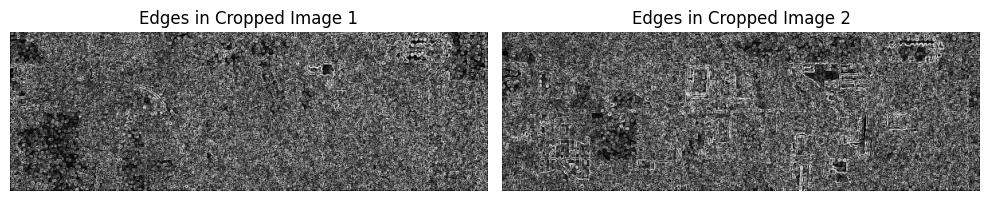

In [50]:
def sobel_edge_detection(image):
    """
    Apply Sobel edge detection to highlight edges.
    :param image: Input image (numpy array).
    :return: Edge-detected image.
    """
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return sobel

# Apply Sobel edge detection to both images
edges_image1 = sobel_edge_detection(cropped_image1)
edges_image2 = sobel_edge_detection(cropped_image2)

# Display the edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges_image1, cmap='gray')
plt.title("Edges in Cropped Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges_image2, cmap='gray')
plt.title("Edges in Cropped Image 2")
plt.axis("off")

plt.tight_layout()
plt.show()


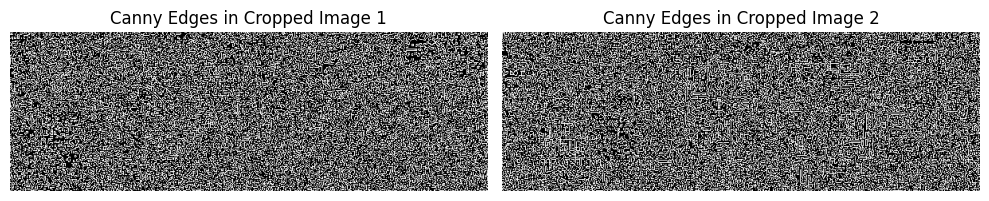

In [51]:
# Apply Canny edge detection
edges_image1 = cv2.Canny(cropped_image1, 100, 200)
edges_image2 = cv2.Canny(cropped_image2, 100, 200)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges_image1, cmap='gray')
plt.title("Canny Edges in Cropped Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges_image2, cmap='gray')
plt.title("Canny Edges in Cropped Image 2")
plt.axis("off")

plt.tight_layout()
plt.show()


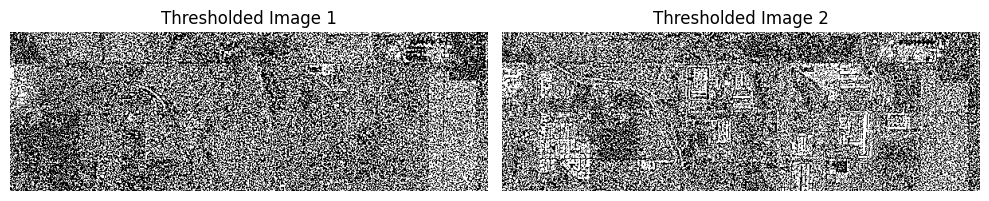

In [52]:
def adaptive_threshold(image):
    """
    Apply adaptive thresholding to highlight structures.
    :param image: Input grayscale image (numpy array).
    :return: Thresholded image.
    """
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply adaptive thresholding
thresh_image1 = adaptive_threshold(cropped_image1)
thresh_image2 = adaptive_threshold(cropped_image2)

# Display thresholded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(thresh_image1, cmap='gray')
plt.title("Thresholded Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(thresh_image2, cmap='gray')
plt.title("Thresholded Image 2")
plt.axis("off")

plt.tight_layout()
plt.show()


In [104]:
import cv2
import matplotlib.pyplot as plt

def reduce_noise(image):
    """
    Apply multiple denoising filters to reduce graininess and enhance clarity.
    :param image: Input image (numpy array).
    :return: Denoised images with various methods.
    """
    # Non-Local Means Denoising
    denoised_nlm = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
    
    # Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Bilateral Filter
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)
    
    # Median Filter
    median_filter = cv2.medianBlur(image, 5)
    
    return denoised_nlm, gaussian_blur, bilateral_filter, median_filter

# Assuming the image is in grayscale (convert it if necessary)
# Replace 'your_image_path.jpg' with your actual image file


# Apply noise reduction filters
denoised_nlm, gaussian_blur, bilateral_filter, median_filter = reduce_noise(sharpened1)

# Display the results
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(sharpened1, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Non-Local Means Denoising
plt.subplot(2, 3, 2)
plt.imshow(denoised_nlm, cmap='gray')
plt.title("Non-Local Means Denoising")
plt.axis("off")

# Gaussian Blur
plt.subplot(2, 3, 3)
plt.imshow(gaussian_blur, cmap='gray')
plt.title("Gaussian Blur")
plt.axis("off")

# Bilateral Filter
plt.subplot(2, 3, 4)
plt.imshow(bilateral_filter, cmap='gray')
plt.title("Bilateral Filter")
plt.axis("off")

# Median Filter
plt.subplot(2, 3, 5)
plt.imshow(median_filter, cmap='gray')
plt.title("Median Filter")
plt.axis("off")

plt.tight_layout()
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\photo\src\denoising.cpp:119: error: (-215:Assertion failed) !_src.empty() in function 'cv::fastNlMeansDenoising'


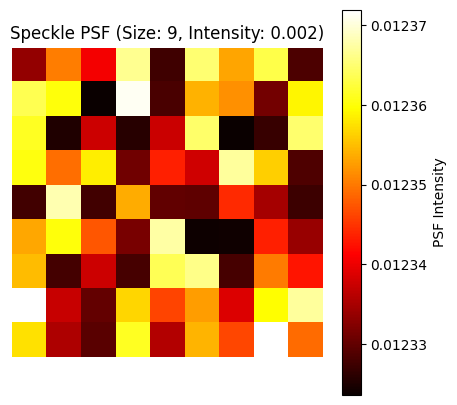

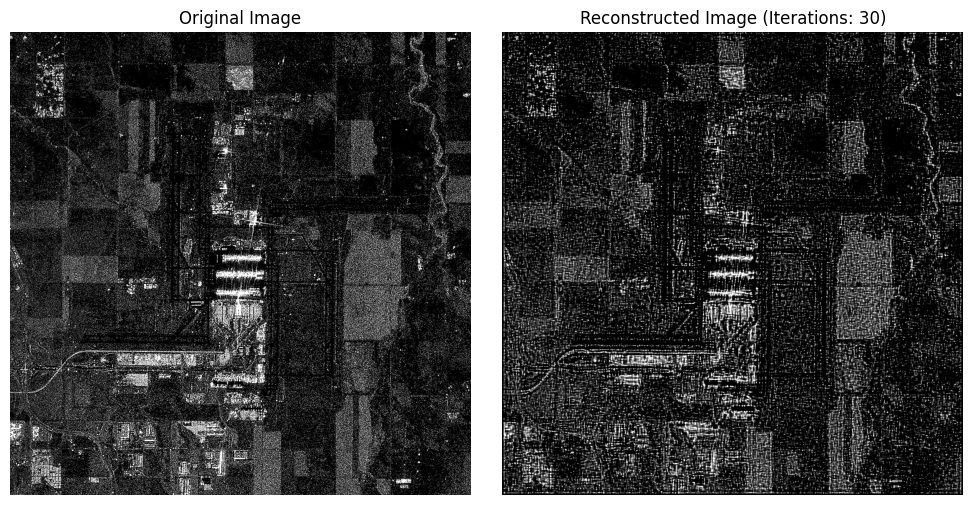

In [92]:
import numpy as np
import cv2
from skimage import restoration
import matplotlib.pyplot as plt

def speckle_psf(size=7, intensity=0.5):
    """
    Generate a speckle Point Spread Function (PSF) for SAR-like noise.
    :param size: Size of the PSF kernel (odd number).
    :param intensity: Intensity of the speckle pattern (float, 0 to 1).
    :return: Speckle PSF kernel.
    """
    # Create a random speckle pattern
    speckle_pattern = np.random.uniform(1 - intensity, 1 + intensity, (size, size))
    
    # Normalize the PSF to ensure it sums to 1
    psf = speckle_pattern / np.sum(speckle_pattern)
    return psf

def lucy_richardson_deconvolution(image, psf, num_iter=30):
    """
    Perform Lucy-Richardson deconvolution on an image.
    :param image: Input blurry image (numpy array).
    :param psf: Point Spread Function (PSF) representing the blur.
    :param num_iter: Number of iterations for the algorithm.
    :return: Reconstructed image.
    """
    # Normalize the image and PSF
    image = image.astype(np.float32) / 255.0
    psf /= psf.sum()
    
    # Perform Lucy-Richardson deconvolution
    reconstructed = restoration.richardson_lucy(image, psf, num_iter=num_iter)
    
    # Scale back to 0-255
    reconstructed = (reconstructed * 255).clip(0, 255).astype(np.uint8)
    return reconstructed

# Adjustable PSF parameters
psf_size = 9  # Size of the PSF kernel (odd number)
psf_intensity = 0.002  # Intensity of speckle variation
num_iterations = 30  # Number of iterations for deconvolution

# Generate the speckle PSF
psf = speckle_psf(size=psf_size, intensity=psf_intensity)

# Visualize the PSF
plt.figure(figsize=(5, 5))
plt.imshow(psf, cmap='hot')
plt.colorbar(label="PSF Intensity")
plt.title(f"Speckle PSF (Size: {psf_size}, Intensity: {psf_intensity})")
plt.axis("off")
plt.show()

# Apply Lucy-Richardson deconvolution
reconstructed_image = lucy_richardson_deconvolution(sharpened2, psf, num_iter=num_iterations)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sharpened2, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (Iterations: {num_iterations})")
plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, gaussian_filter

# Load the image
image_path = "DEN_timelapse\sar_vv_timelapse_01.jpg"
sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(sar_image, cmap='gray')
plt.title("Original SAR Image")
plt.axis("off")
plt.show()



In [ ]:
def simulate_azimuth_effect(image, scaling_factor):
    """Simulates azimuth effect by scaling the image."""
    height, width = image.shape
    new_width = int(width * scaling_factor)
    azimuth_effect_image = cv2.resize(image, (new_width, height))
    return azimuth_effect_image

# Apply azimuth simulation
scaling_factors = [0.5, 1, 1.5]  # Varying azimuth effects
for scale in scaling_factors:
    azimuth_image = simulate_azimuth_effect(sar_image, scale)
    plt.imshow(azimuth_image, cmap='gray')
    plt.title(f"Azimuth Effect (Scale: {scale})")
    plt.axis("off")
    plt.show()


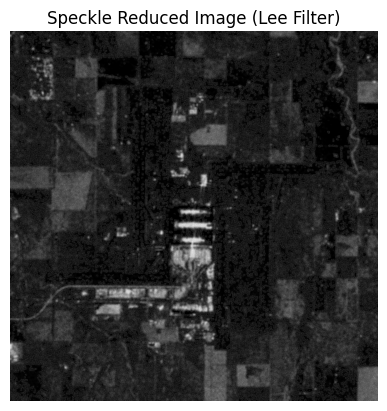

In [37]:
def lee_filter(image, size=5):
    """Applies Lee filter for speckle noise reduction."""
    img_mean = uniform_filter(image, (size, size))
    img_sqr_mean = uniform_filter(image**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = np.var(image)

    img_weights = img_variance / (img_variance + overall_variance)
    img_filtered = img_mean + img_weights * (image - img_mean)
    return img_filtered

# Apply Lee filter
filtered_image = lee_filter(sar_image)
plt.imshow(filtered_image, cmap='gray')
plt.title("Speckle Reduced Image (Lee Filter)")
plt.axis("off")
plt.show()


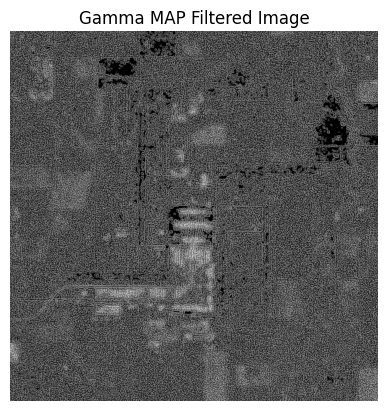

In [38]:
def gamma_map_filter(image, kernel_size=5, gamma_factor=1.0):
    """
    Applies Gamma MAP filter for speckle noise reduction.
    :param image: Input SAR image (numpy array).
    :param kernel_size: Size of the sliding window.
    :param gamma_factor: Gamma distribution shape parameter (greater than 0).
    :return: Gamma MAP filtered image.
    """
    img_mean = uniform_filter(image, size=kernel_size)
    img_variance = uniform_filter(image**2, size=kernel_size) - img_mean**2
    
    # Gamma MAP estimation
    noise_var = img_variance / (gamma_factor + 1e-6)
    filtered = img_mean + noise_var * ((image - img_mean) / (noise_var + gamma_factor))
    return filtered

# Apply Gamma MAP filter
gamma_filtered = gamma_map_filter(sar_image, kernel_size=5, gamma_factor=1.0)
plt.imshow(gamma_filtered, cmap='gray')
plt.title("Gamma MAP Filtered Image")
plt.axis("off")
plt.show()


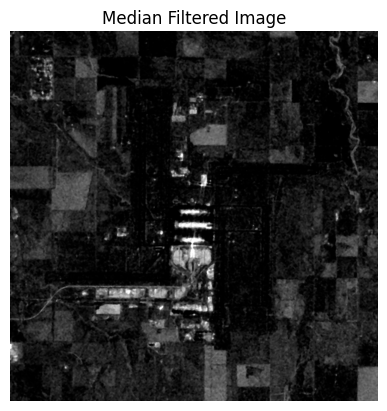

In [39]:
from scipy.ndimage import median_filter

def apply_median_filter(image, kernel_size=5):
    """
    Applies Median filter to reduce speckle noise.
    :param image: Input SAR image (numpy array).
    :param kernel_size: Size of the sliding window.
    :return: Median-filtered image.
    """
    filtered = median_filter(image, size=kernel_size)
    return filtered

# Apply Median filter
median_filtered = apply_median_filter(sar_image, kernel_size=5)
plt.imshow(median_filtered, cmap='gray')
plt.title("Median Filtered Image")
plt.axis("off")
plt.show()


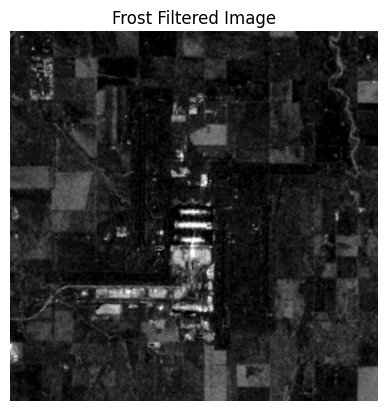

In [40]:
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter

def frost_filter(image, damping_factor=2.0, kernel_size=5):
    """
    Applies Frost filter to reduce speckle noise in an image.
    :param image: Input SAR image (numpy array).
    :param damping_factor: Controls the damping effect; higher means more smoothing.
    :param kernel_size: Size of the sliding window (odd number).
    :return: Frost-filtered image.
    """
    img_mean = uniform_filter(image, size=kernel_size)
    img_variance = uniform_filter(image**2, size=kernel_size) - img_mean**2
    stddev = np.sqrt(img_variance)
    
    # Weighting function
    weights = np.exp(-damping_factor * np.abs(image - img_mean) / (stddev + 1e-6))
    weights /= uniform_filter(weights, size=kernel_size)
    
    # Filtered image
    filtered = uniform_filter(image * weights, size=kernel_size) / uniform_filter(weights, size=kernel_size)
    return filtered

# Apply Frost filter
frost_filtered = frost_filter(sar_image, damping_factor=2.0, kernel_size=5)
plt.imshow(frost_filtered, cmap='gray')
plt.title("Frost Filtered Image")
plt.axis("off")
plt.show()
